In [14]:
import rasterio
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# 1. family change function
def lc_change(tp):
    tp_lc = tp['family']
    # family string to int
    tp_lc = tp_lc.to_frame()
    lc_list = {'family':{'Fabaceae / Leguminosae - Pea family':'1', 'Platanaceae - Plane-tree family':'2', 'Aceraceae - Maple family':'3',
                         'Fagaceae - Beech family':'4', 'Rosaceae - Rose family':'5', 'Conifer':'6', 'broad-leaf tree':'7'}}
    tp_lc = tp_lc.replace(lc_list)
    
    # change
    tp.drop(['Lat', 'Long', 'family'], axis = 1, inplace=True)
    tp = pd.concat([tp, tp_lc], axis=1)
    
    return tp

In [21]:
# 2. data pretreatment
def treatment(tp):
    ex = tp.drop(tp[tp['family'] == 'Unidentifiable'].index)
    ex = ex.dropna()
    ex.reset_index(drop=True)
    return ex

# 1. Point Sampling

In [22]:
# 2. Set the feature & area
feature = ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
           "MEAN", "VAR", "HOMO", "CONT", "DISSI", "ENTROPY", "SECOND", "CORR"]
area = ['manup', 'mandown', 'br']
# ['NDVI', 'SBI', 'GVI', 'YVI', 'WBI'], 'outglcm_mandown'
# ['NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']'br', 'brleft', 'manup', 'brup', 'manmid' 'mandown'
# "mean", "variance", "homogeneity", "contrast",  "dissimilarity", "entropy", "second_moment", "correlation"
for i in feature:
    for j in area:
        globals()[f'{i}{j}_file'] = '../KOMPSAT 위성영상/데이터 전처리/4. data/'+j+'/'+i+'.tif'
        globals()[f'{i}{j}_src'] = rasterio.open(globals()[f'{i}{j}_file'])

In [23]:
def onlyPointSampling(file, src, tp):
    ttp = pd.DataFrame()
    ttp['geometry'] = [(x,y) for x,y in zip(tp['geometry'].x , tp['geometry'].y)]
    # 해당 dataframe으로 포인트 샘플링 실행
    ttp[Path(file).stem] = [x for x in src.sample(ttp['geometry'])] # 포인트 샘플링
    ttp[Path(file).stem] = ttp[Path(file).stem].astype('float64') # NDVI 값을 float으로 바꿈
    ttp.drop(['geometry'], axis=1, inplace=True)

    return ttp

# 2. Data pretreatment

In [24]:
# 4. delete the 3by3 kernel NDVI values under 0.2 
def NDVIkn02(tp):
    ttp = pd.DataFrame()    
    ttp = tp.drop(tp[tp['NDVI']<0.2].index)
    ttp.reset_index(drop=True)
    return ttp

# 3. Run

In [25]:
# data load
tp_manup = gpd.GeoDataFrame.from_file("Detection_man_training_treepoint/Detection_manup_training_yvalue.shp")
tp_mandown = gpd.GeoDataFrame.from_file("Detection_man_training_treepoint/Detection_mandown_training_yvalue.shp")

tp_brActual = gpd.GeoDataFrame.from_file("Actual_all_treepoint_family/br_test.shp")
tp_brDetect = gpd.GeoDataFrame.from_file("Detection_br_test_treepoint/Detection_br_test_verif.shp")

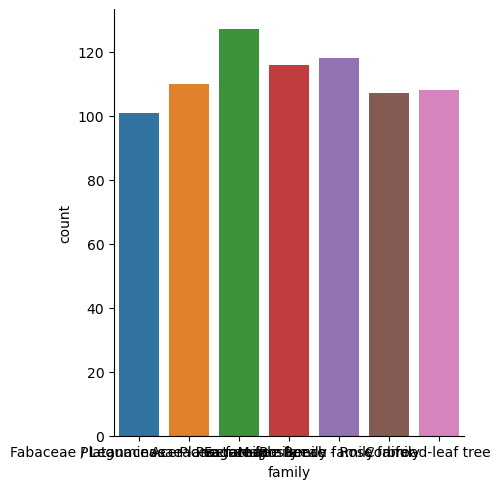

(101, 4) (110, 4) (127, 4) (116, 4) (118, 4) (107, 4) (108, 4)


In [26]:
sns.catplot(x="family", kind="count", order=['Fabaceae / Leguminosae - Pea family', 'Platanaceae - Plane-tree family', 'Aceraceae - Maple family',
                         'Fagaceae - Beech family', 'Rosaceae - Rose family', 'Conifer', 'broad-leaf tree'], data=tp_manup) # order: 보여지는 순서
plt.show()
# 분류항목 확인
lc_list = ['Fabaceae / Leguminosae - Pea family', 'Platanaceae - Plane-tree family', 'Aceraceae - Maple family',
                         'Fagaceae - Beech family', 'Rosaceae - Rose family', 'Conifer', 'broad-leaf tree']
for i in range(7):
    globals()[f'lc{i}'] = tp_manup[tp_manup['family'] == lc_list[i]]
print(lc0.shape, lc1.shape, lc2.shape, lc3.shape, lc4.shape, lc5.shape, lc6.shape)

In [27]:
tp_brActual

,OBJECTID,Lat,Long,GenusSpeci,family,geometry
0,720621,40.642354,-73.953426,Platanus x acerifolia - London planetree,Platanaceae - Plane-tree family,POINT (-73.95343 40.64235)
1,1258918,40.661592,-73.949450,Acer platanoides - Norway maple,Aceraceae - Maple family,POINT (-73.94945 40.66159)
2,893890,40.655752,-73.947275,Cryptomeria japonica - Japanese cedar,Conifer,POINT (-73.94728 40.65575)
3,933894,40.660973,-73.950746,Prunus serrulata 'Green leaf' - 'Green leaf' J...,Rosaceae - Rose family,POINT (-73.95075 40.66097)
4,301789,40.660529,-73.956216,Platanus x acerifolia - London planetree,Platanaceae - Plane-tree family,POINT (-73.95622 40.66053)
...,...,...,...,...,...,...
15678,5291835,40.639632,-73.939654,Cercis canadensis - eastern redbud,Fabaceae / Leguminosae - Pea family,POINT (-73.93965 40.63963)
15679,5609479,40.661859,-73.961403,Ginkgo biloba - maidenhair tree,Conifer,POINT (-73.96140 40.66186)
15680,5294635,40.638137,-73.938517,Zelkova serrata - Japanese zelkova,broad-leaf tree,POINT (-73.93852 40.63814)
15681,5291834,40.639872,-73.939676,Prunus 'Mt Fuji' - 'Mt Fuji' Cherry,Rosaceae - Rose family,POINT (-73.93968 40.63987)


In [28]:
# 1. Data pretreatment - unident del
manup = treatment(tp_manup)
mandown = treatment(tp_mandown)
brDetect = treatment(tp_brDetect)
brDetect

,Long,Lat,family,geometry
6,-73.961427,40.670737,Fabaceae / Leguminosae - Pea family,POINT (-73.96143 40.67074)
9,-73.962103,40.670607,Rosaceae - Rose family,POINT (-73.96210 40.67061)
16,-73.960219,40.670245,Rosaceae - Rose family,POINT (-73.96022 40.67025)
17,-73.957161,40.670227,broad-leaf tree,POINT (-73.95716 40.67023)
21,-73.956385,40.670133,broad-leaf tree,POINT (-73.95639 40.67013)
...,...,...,...,...
5239,-73.942480,40.637980,Aceraceae - Maple family,POINT (-73.94248 40.63798)
5240,-73.936935,40.637020,Aceraceae - Maple family,POINT (-73.93693 40.63702)
5241,-73.931579,40.636641,Aceraceae - Maple family,POINT (-73.93158 40.63664)
5242,-73.938345,40.636452,Aceraceae - Maple family,POINT (-73.93835 40.63645)


In [29]:
mandown

,Long,Lat,family,geometry
0,-74.003127,40.759399,Fabaceae / Leguminosae - Pea family,POINT (-74.00313 40.75940)
68,-73.976903,40.759109,Fabaceae / Leguminosae - Pea family,POINT (-73.97690 40.75911)
126,-73.977037,40.758988,Fabaceae / Leguminosae - Pea family,POINT (-73.97704 40.75899)
223,-73.970504,40.758838,Fagaceae - Beech family,POINT (-73.97050 40.75884)
236,-73.977142,40.758823,Fabaceae / Leguminosae - Pea family,POINT (-73.97714 40.75882)
...,...,...,...,...
43390,-73.999854,40.716054,Conifer,POINT (-73.99985 40.71606)
43418,-73.999785,40.716029,Conifer,POINT (-73.99979 40.71603)
43443,-73.999724,40.716010,Conifer,POINT (-73.99972 40.71601)
43497,-73.999590,40.715958,Conifer,POINT (-73.99959 40.71596)


In [30]:
# 1. run family change
manup = lc_change(manup)
mandown = lc_change(mandown)
brDetect = lc_change(brDetect)
tp_sc = tp_brActual['family']
# family string to int
tp_sc = tp_sc.to_frame()
sc_list = {'family':{'Fabaceae / Leguminosae - Pea family':'1', 'Platanaceae - Plane-tree family':'2', 'Aceraceae - Maple family':'3',
                     'Fagaceae - Beech family':'4', 'Rosaceae - Rose family':'5', 'Conifer':'6', 'broad-leaf tree':'7'}}
tp_sc = tp_sc.replace(sc_list)
# change
tp_brActual.drop(["GenusSpeci", "OBJECTID", "Lat", "Long", 'family'], axis = 1, inplace=True)
brActual = pd.concat([tp_brActual, tp_sc], axis=1)

In [31]:
mandown

,geometry,family
0,POINT (-74.00313 40.75940),1
68,POINT (-73.97690 40.75911),1
126,POINT (-73.97704 40.75899),1
223,POINT (-73.97050 40.75884),4
236,POINT (-73.97714 40.75882),1
...,...,...
43390,POINT (-73.99985 40.71606),6
43418,POINT (-73.99979 40.71603),6
43443,POINT (-73.99972 40.71601),6
43497,POINT (-73.99959 40.71596),6


In [32]:
brActual

,geometry,family
0,POINT (-73.95343 40.64235),2
1,POINT (-73.94945 40.66159),3
2,POINT (-73.94728 40.65575),6
3,POINT (-73.95075 40.66097),5
4,POINT (-73.95622 40.66053),2
...,...,...
15678,POINT (-73.93965 40.63963),1
15679,POINT (-73.96140 40.66186),6
15680,POINT (-73.93852 40.63814),7
15681,POINT (-73.93968 40.63987),5


In [33]:
# 3-1. Create tp's LC columns
manupLC = manup.drop(['geometry'], axis=1)
mandownLC = mandown.drop(['geometry'], axis=1)
brDetectLC = brDetect.drop(['geometry'], axis=1)
brActualLC = brActual.drop(['geometry'], axis=1)
manupLC.reset_index(drop=True, inplace=True)
mandownLC.reset_index(drop=True, inplace=True)
brDetectLC.reset_index(drop=True, inplace=True)
brActualLC.reset_index(drop=True, inplace=True)
brDetectLC

,family
0,1
1,5
2,5
3,7
4,7
...,...
1995,3
1996,3
1997,3
1998,3


In [34]:
# 3-2. run 3by3 onlyPointSampling
# 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI'
# 'NDVI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI'
# manup
manupNDVI = onlyPointSampling(NDVImanup_file, NDVImanup_src, manup)
manupSBI = onlyPointSampling(SBImanup_file, SBImanup_src, manup)
manupGVI = onlyPointSampling(GVImanup_file, GVImanup_src, manup)
manupYVI = onlyPointSampling(YVImanup_file, YVImanup_src, manup)
manupWBI = onlyPointSampling(WBImanup_file, WBImanup_src, manup)
manupGCI = onlyPointSampling(GCImanup_file, GCImanup_src, manup)
manupAVI = onlyPointSampling(AVImanup_file, AVImanup_src, manup)
manupSIPI = onlyPointSampling(SIPImanup_file, SIPImanup_src, manup)
manupARVI = onlyPointSampling(ARVImanup_file, ARVImanup_src, manup)
manupEVI = onlyPointSampling(EVImanup_file, EVImanup_src, manup)
# GLCM
manupMEAN = onlyPointSampling(MEANmanup_file, MEANmanup_src, manup)
manupVAR = onlyPointSampling(VARmanup_file, VARmanup_src, manup)
manupHOMO = onlyPointSampling(HOMOmanup_file, HOMOmanup_src, manup)
manupCONT = onlyPointSampling(CONTmanup_file, CONTmanup_src, manup)
manupDISSI = onlyPointSampling(DISSImanup_file, DISSImanup_src, manup)
manupENTROPY = onlyPointSampling(ENTROPYmanup_file, ENTROPYmanup_src, manup)
manupSECOND = onlyPointSampling(SECONDmanup_file, SECONDmanup_src, manup)
manupCORR = onlyPointSampling(CORRmanup_file, CORRmanup_src, manup)

In [35]:
manupS = pd.concat([manupLC, manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI,
                   ], axis=1, ignore_index=True)
manupSG = pd.concat([manupLC, manupNDVI, manupSBI, manupGVI, manupYVI, manupWBI, manupGCI, manupAVI, manupSIPI, manupARVI, manupEVI,
                   manupMEAN, manupVAR, manupHOMO, manupCONT, manupDISSI, manupENTROPY, manupSECOND, manupCORR
                    ], axis=1, ignore_index=True)
manupS.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']
manupSG.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                  "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [36]:
manupS

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,2,0.449799,0.298280,0.083347,-0.016917,-0.013949,1.039924,0.010760,0.728839,0.341932,0.463141
1,2,0.528892,0.317979,0.126732,-0.018384,-0.019453,1.641601,0.017225,0.797843,0.402915,0.579876
2,4,0.522188,0.302055,0.106137,-0.017910,-0.007879,1.245395,0.014189,0.764795,0.402971,0.541707
3,2,0.481356,0.304262,0.095849,-0.014294,-0.015841,1.222836,0.012608,0.730870,0.370651,0.520641
4,2,0.375739,0.271016,0.056663,-0.009948,-0.022487,0.927683,0.006722,0.635918,0.291040,0.360450
...,...,...,...,...,...,...,...,...,...,...,...
782,5,0.219071,0.305861,0.022030,-0.022619,-0.027119,0.435591,0.003954,0.570859,0.166983,0.222772
783,6,0.201993,0.156220,-0.010758,0.010603,-0.007265,0.058928,0.000664,-0.799288,0.261601,0.103630
784,5,0.240866,0.182489,0.001292,0.007403,-0.014248,0.308389,0.001319,-0.152733,0.254577,0.153854
785,3,0.202789,0.235815,0.001146,-0.007013,-0.013944,0.214862,0.001882,0.124248,0.192618,0.163253


In [37]:
manupSG

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.449799,0.298280,0.083347,-0.016917,-0.013949,1.039924,0.010760,0.728839,0.341932,0.463141,0.203750,63.033989,0.821769,3.8208,0.6576,2.343803,0.203485,0.921151
1,2,0.528892,0.317979,0.126732,-0.018384,-0.019453,1.641601,0.017225,0.797843,0.402915,0.579876,0.242388,87.777626,0.833767,4.8832,0.6600,2.201375,0.202931,0.928623
2,4,0.522188,0.302055,0.106137,-0.017910,-0.007879,1.245395,0.014189,0.764795,0.402971,0.541707,0.241850,65.340111,0.697489,1.8288,0.7832,3.468864,0.052499,0.920500
3,2,0.481356,0.304262,0.095849,-0.014294,-0.015841,1.222836,0.012608,0.730870,0.370651,0.520641,0.257269,91.668144,0.726444,5.6828,0.9676,3.056463,0.126934,0.908161
4,2,0.375739,0.271016,0.056663,-0.009948,-0.022487,0.927683,0.006722,0.635918,0.291040,0.360450,0.212612,64.191360,0.729394,5.0504,0.9656,3.146740,0.127292,0.892063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,5,0.219071,0.305861,0.022030,-0.022619,-0.027119,0.435591,0.003954,0.570859,0.166983,0.222772,0.205637,49.460621,0.668965,3.4696,1.0064,3.489103,0.077134,0.828415
783,6,0.201993,0.156220,-0.010758,0.010603,-0.007265,0.058928,0.000664,-0.799288,0.261601,0.103630,0.189656,43.548565,0.592376,4.1844,1.2548,3.848853,0.045500,0.780364
784,5,0.240866,0.182489,0.001292,0.007403,-0.014248,0.308389,0.001319,-0.152733,0.254577,0.153854,0.214806,54.704693,0.707738,1.5276,0.7300,3.427190,0.062638,0.937007
785,3,0.202789,0.235815,0.001146,-0.007013,-0.013944,0.214862,0.001882,0.124248,0.192618,0.163253,0.272969,81.161377,0.645037,2.9452,0.9892,3.784041,0.035745,0.863560


In [38]:
# mandown
mandownNDVI = onlyPointSampling(NDVImandown_file, NDVImandown_src, mandown)
mandownSBI = onlyPointSampling(SBImandown_file, SBImandown_src, mandown)
mandownGVI = onlyPointSampling(GVImandown_file, GVImandown_src, mandown)
mandownYVI = onlyPointSampling(YVImandown_file, YVImandown_src, mandown)
mandownWBI = onlyPointSampling(WBImandown_file, WBImandown_src, mandown)
mandownGCI = onlyPointSampling(GCImandown_file, GCImandown_src, mandown)
mandownAVI = onlyPointSampling(AVImandown_file, AVImandown_src, mandown)
mandownSIPI = onlyPointSampling(SIPImandown_file, SIPImandown_src, mandown)
mandownARVI = onlyPointSampling(ARVImandown_file, ARVImandown_src, mandown)
mandownEVI = onlyPointSampling(EVImandown_file, EVImandown_src, mandown)
# GLCM
mandownMEAN = onlyPointSampling(MEANmandown_file, MEANmandown_src, mandown)
mandownVAR = onlyPointSampling(VARmandown_file, VARmandown_src, mandown)
mandownHOMO = onlyPointSampling(HOMOmandown_file, HOMOmandown_src, mandown)
mandownCONT = onlyPointSampling(CONTmandown_file, CONTmandown_src, mandown)
mandownDISSI = onlyPointSampling(DISSImandown_file, DISSImandown_src, mandown)
mandownENTROPY = onlyPointSampling(ENTROPYmandown_file, ENTROPYmandown_src, mandown)
mandownSECOND = onlyPointSampling(SECONDmandown_file, SECONDmandown_src, mandown)
mandownCORR = onlyPointSampling(CORRmandown_file, CORRmandown_src, mandown)

In [39]:
mandownS = pd.concat([mandownLC, mandownNDVI, mandownSBI, mandownGVI, mandownYVI, mandownWBI, mandownGCI, mandownAVI, mandownSIPI, mandownARVI, mandownEVI,
                   ], axis=1, ignore_index=True)
mandownSG = pd.concat([mandownLC, mandownNDVI, mandownSBI, mandownGVI, mandownYVI, mandownWBI, mandownGCI, mandownAVI, mandownSIPI, mandownARVI, mandownEVI,
                   mandownMEAN, mandownVAR, mandownHOMO, mandownCONT, mandownDISSI, mandownENTROPY, mandownSECOND, mandownCORR
                    ], axis=1, ignore_index=True)
mandownS.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']
mandownSG.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                  "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [40]:
mandownS

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,1,0.640712,0.346124,0.168590,-0.016702,-0.004411,1.844706,0.027206,0.792763,0.518402,0.801828
1,1,0.362288,0.261248,0.054886,-0.010189,-0.025812,0.988430,0.006109,0.650840,0.277056,0.329066
2,1,0.400039,0.296066,0.064775,-0.013035,-0.016866,0.863069,0.008532,0.654042,0.309738,0.424104
3,4,0.379944,0.317340,0.075515,-0.024551,-0.022807,0.944233,0.009767,0.769532,0.273778,0.397380
4,1,0.483965,0.282518,0.090816,-0.014561,-0.014355,1.237598,0.011134,0.744043,0.370654,0.471305
...,...,...,...,...,...,...,...,...,...,...,...
784,6,0.282032,0.386990,0.061988,-0.040443,-0.033954,0.685080,0.009354,0.819819,0.188179,0.342877
785,6,0.345640,0.403220,0.083558,-0.037413,-0.027609,0.800910,0.013241,0.793904,0.241583,0.458810
786,6,0.230226,0.416955,0.049669,-0.049195,-0.040042,0.560775,0.008188,0.860030,0.145644,0.291453
787,6,0.219792,0.404550,0.038619,-0.040675,-0.038480,0.500216,0.007030,0.748603,0.149851,0.288065


In [41]:
mandownSG

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,1,0.640712,0.346124,0.168590,-0.016702,-0.004411,1.844706,0.027206,0.792763,0.518402,0.801828,0.230406,90.597313,0.780390,7.0956,0.9268,2.766723,0.214641,0.914263
1,1,0.362288,0.261248,0.054886,-0.010189,-0.025812,0.988430,0.006109,0.650840,0.277056,0.329066,0.229956,56.437904,0.579194,5.4516,1.3540,3.860749,0.033582,0.548881
2,1,0.400039,0.296066,0.064775,-0.013035,-0.016866,0.863069,0.008532,0.654042,0.309738,0.424104,0.267462,74.515984,0.676231,2.6208,0.9016,3.482474,0.057862,0.744278
3,4,0.379944,0.317340,0.075515,-0.024551,-0.022807,0.944233,0.009767,0.769532,0.273778,0.397380,0.254512,69.333626,0.673341,1.9808,0.8392,3.615522,0.044396,0.858238
4,1,0.483965,0.282518,0.090816,-0.014561,-0.014355,1.237598,0.011134,0.744043,0.370654,0.471305,0.244819,62.404263,0.606291,2.6388,1.0548,3.686812,0.035649,0.730837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,6,0.282032,0.386990,0.061988,-0.040443,-0.033954,0.685080,0.009354,0.819819,0.188179,0.342877,0.247169,66.108940,0.573028,3.6836,1.2404,4.008459,0.028280,0.762958
785,6,0.345640,0.403220,0.083558,-0.037413,-0.027609,0.800910,0.013241,0.793904,0.241583,0.458810,0.249956,68.771187,0.547515,4.0916,1.3244,4.091058,0.023492,0.746481
786,6,0.230226,0.416955,0.049669,-0.049195,-0.040042,0.560775,0.008188,0.860030,0.145644,0.291453,0.226025,60.233128,0.592855,3.9200,1.2008,3.930270,0.029906,0.816128
787,6,0.219792,0.404550,0.038619,-0.040675,-0.038480,0.500216,0.007030,0.748603,0.149851,0.288065,0.128031,26.144325,0.809760,2.3988,0.5932,2.486631,0.220468,0.880414


In [147]:
# brDetect
brDetectNDVI = onlyPointSampling(NDVIbr_file, NDVIbr_src, brDetect)
brDetectSBI = onlyPointSampling(SBIbr_file, SBIbr_src, brDetect)
brDetectGVI = onlyPointSampling(GVIbr_file, GVIbr_src, brDetect)
brDetectYVI = onlyPointSampling(YVIbr_file, YVIbr_src, brDetect)
brDetectWBI = onlyPointSampling(WBIbr_file, WBIbr_src, brDetect)
brDetectGCI = onlyPointSampling(GCIbr_file, GCIbr_src, brDetect)
brDetectAVI = onlyPointSampling(AVIbr_file, AVIbr_src, brDetect)
brDetectSIPI = onlyPointSampling(SIPIbr_file, SIPIbr_src, brDetect)
brDetectARVI = onlyPointSampling(ARVIbr_file, ARVIbr_src, brDetect)
brDetectEVI = onlyPointSampling(EVIbr_file, EVIbr_src, brDetect)
# GLCM
brDetectMEAN = onlyPointSampling(MEANbr_file, MEANbr_src, brDetect)
brDetectVAR = onlyPointSampling(VARbr_file, VARbr_src, brDetect)
brDetectHOMO = onlyPointSampling(HOMObr_file, HOMObr_src, brDetect)
brDetectCONT = onlyPointSampling(CONTbr_file, CONTbr_src, brDetect)
brDetectDISSI = onlyPointSampling(DISSIbr_file, DISSIbr_src, brDetect)
brDetectENTROPY = onlyPointSampling(ENTROPYbr_file, ENTROPYbr_src, brDetect)
brDetectSECOND = onlyPointSampling(SECONDbr_file, SECONDbr_src, brDetect)
brDetectCORR = onlyPointSampling(CORRbr_file, CORRbr_src, brDetect)

In [148]:
brDetectS = pd.concat([brDetectLC, brDetectNDVI, brDetectSBI, brDetectGVI, brDetectYVI, brDetectWBI, brDetectGCI, brDetectAVI, brDetectSIPI, brDetectARVI, brDetectEVI,
                   ], axis=1, ignore_index=True)
brDetectSG = pd.concat([brDetectLC, brDetectNDVI, brDetectSBI, brDetectGVI, brDetectYVI, brDetectWBI, brDetectGCI, brDetectAVI, brDetectSIPI, brDetectARVI, brDetectEVI,
                   brDetectMEAN, brDetectVAR, brDetectHOMO, brDetectCONT, brDetectDISSI, brDetectENTROPY, brDetectSECOND, brDetectCORR
                    ], axis=1, ignore_index=True)
brDetectS.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']
brDetectSG.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                  "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [149]:
brDetectS

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,1,0.497691,0.302976,0.100823,-0.020731,-0.008972,0.0,0.0,0.0,0.0,0.0
1,5,0.696190,0.362867,0.217330,-0.022917,-0.006648,0.0,0.0,0.0,0.0,0.0
2,5,0.275884,0.250853,0.033685,-0.011642,-0.029185,0.0,0.0,0.0,0.0,0.0
3,7,0.243782,0.333793,0.044488,-0.031668,-0.038639,0.0,0.0,0.0,0.0,0.0
4,7,0.634993,0.224901,0.095778,0.003659,-0.007134,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1995,3,0.407680,0.295629,0.079585,-0.014130,-0.028465,0.0,0.0,0.0,0.0,0.0
1996,3,0.539983,0.307562,0.120616,-0.016492,-0.014227,0.0,0.0,0.0,0.0,0.0
1997,3,0.452098,0.282844,0.066583,-0.009094,-0.006684,0.0,0.0,0.0,0.0,0.0
1998,3,0.470635,0.322896,0.113583,-0.020351,-0.027465,0.0,0.0,0.0,0.0,0.0


In [150]:
brDetectSG

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,1,0.497691,0.302976,0.100823,-0.020731,-0.008972,0.0,0.0,0.0,0.0,0.0,111.143463,111.143463,0.707186,1.4756,0.7196,3.498310,0.049207,0.926442
1,5,0.696190,0.362867,0.217330,-0.022917,-0.006648,0.0,0.0,0.0,0.0,0.0,266.619690,266.619690,0.637702,1.8320,0.8984,3.866780,0.032828,0.912577
2,5,0.275884,0.250853,0.033685,-0.011642,-0.029185,0.0,0.0,0.0,0.0,0.0,85.348999,85.348999,0.667095,2.3928,0.9112,3.575053,0.074346,0.895182
3,7,0.243782,0.333793,0.044488,-0.031668,-0.038639,0.0,0.0,0.0,0.0,0.0,108.212616,108.212616,0.525176,5.8336,1.5432,4.452185,0.018065,0.801278
4,7,0.634993,0.224901,0.095778,0.003659,-0.007134,0.0,0.0,0.0,0.0,0.0,138.938461,138.938461,0.594057,2.3640,1.0472,4.164482,0.021884,0.902903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,0.407680,0.295629,0.079585,-0.014130,-0.028465,0.0,0.0,0.0,0.0,0.0,74.410591,74.410591,0.655734,4.1772,1.0580,3.615613,0.043615,0.741108
1996,3,0.539983,0.307562,0.120616,-0.016492,-0.014227,0.0,0.0,0.0,0.0,0.0,119.586937,119.586937,0.592734,3.6764,1.1572,3.874662,0.030883,0.783311
1997,3,0.452098,0.282844,0.066583,-0.009094,-0.006684,0.0,0.0,0.0,0.0,0.0,83.655083,83.655083,0.611416,2.8188,1.0524,3.678502,0.040448,0.696480
1998,3,0.470635,0.322896,0.113583,-0.020351,-0.027465,0.0,0.0,0.0,0.0,0.0,103.100220,103.100220,0.665118,1.2924,0.7708,3.508638,0.043041,0.851631


In [151]:
# 한 번 그냥 정확도 어떤지 궁금해서 함 봐보는 용도.. brActual
brActualNDVI = onlyPointSampling(NDVIbr_file, NDVIbr_src, brActual)
brActualSBI = onlyPointSampling(SBIbr_file, SBIbr_src, brActual)
brActualGVI = onlyPointSampling(GVIbr_file, GVIbr_src, brActual)
brActualYVI = onlyPointSampling(YVIbr_file, YVIbr_src, brActual)
brActualWBI = onlyPointSampling(WBIbr_file, WBIbr_src, brActual)
brActualGCI = onlyPointSampling(GCIbr_file, GCIbr_src, brActual)
brActualAVI = onlyPointSampling(AVIbr_file, AVIbr_src, brActual)
brActualSIPI = onlyPointSampling(SIPIbr_file, SIPIbr_src, brActual)
brActualARVI = onlyPointSampling(ARVIbr_file, ARVIbr_src, brActual)
brActualEVI = onlyPointSampling(EVIbr_file, EVIbr_src, brActual)
# GLCM
brActualMEAN = onlyPointSampling(MEANbr_file, MEANbr_src, brActual)
brActualVAR = onlyPointSampling(VARbr_file, VARbr_src, brActual)
brActualHOMO = onlyPointSampling(HOMObr_file, HOMObr_src, brActual)
brActualCONT = onlyPointSampling(CONTbr_file, CONTbr_src, brActual)
brActualDISSI = onlyPointSampling(DISSIbr_file, DISSIbr_src, brActual)
brActualENTROPY = onlyPointSampling(ENTROPYbr_file, ENTROPYbr_src, brActual)
brActualSECOND = onlyPointSampling(SECONDbr_file, SECONDbr_src, brActual)
brActualCORR = onlyPointSampling(CORRbr_file, CORRbr_src, brActual)

In [152]:
brActualS = pd.concat([brActualLC, brActualNDVI, brActualSBI, brActualGVI, brActualYVI, brActualWBI, brActualGCI, brActualAVI, brActualSIPI, brActualARVI, brActualEVI,
                   ], axis=1, ignore_index=True)
brActualSG = pd.concat([brActualLC, brActualNDVI, brActualSBI, brActualGVI, brActualYVI, brActualWBI, brActualGCI, brActualAVI, brActualSIPI, brActualARVI, brActualEVI,
                   brActualMEAN, brActualVAR, brActualHOMO, brActualCONT, brActualDISSI, brActualENTROPY, brActualSECOND, brActualCORR
                    ], axis=1, ignore_index=True)
brActualS.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI']
brActualSG.columns = ['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI', 'ARVI', 'EVI', 
                  "MEAN", "VAR", "HOMO", "CONT",  "DISSI", "ENTROPY", "SECOND", "CORR"]

In [153]:
brActualSG

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI,MEAN,VAR,HOMO,CONT,DISSI,ENTROPY,SECOND,CORR
0,2,0.318061,0.309105,0.046529,-0.017101,-0.022574,0.0,0.0,0.0,0.0,0.0,90.631065,90.631065,0.653502,2.2780,0.9108,3.670007,0.049070,0.820424
1,3,0.008160,0.311438,-0.036762,-0.027500,-0.026577,0.0,0.0,0.0,0.0,0.0,77.863335,77.863335,0.600879,2.4604,1.0428,3.876785,0.028376,0.807099
2,6,0.030536,0.224125,-0.033610,-0.001753,-0.014746,0.0,0.0,0.0,0.0,0.0,65.017532,65.017532,0.728900,1.0256,0.6208,3.071522,0.071668,0.832312
3,5,0.040049,0.323130,-0.022151,-0.029778,-0.038771,0.0,0.0,0.0,0.0,0.0,57.557636,57.557636,0.539844,8.3012,1.6588,4.075690,0.030049,0.583523
4,2,0.409952,0.311289,0.077786,-0.020210,-0.018079,0.0,0.0,0.0,0.0,0.0,114.518768,114.518768,0.670106,1.7164,0.8156,3.342672,0.063547,0.776417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15678,1,0.003297,0.421112,-0.027749,-0.067822,-0.052692,0.0,0.0,0.0,0.0,0.0,107.868629,107.868629,0.597042,2.4020,1.0460,3.994095,0.026922,0.878783
15679,6,-0.003495,0.339910,-0.035726,-0.032386,-0.041164,0.0,0.0,0.0,0.0,0.0,60.929482,60.929482,0.650856,2.6512,0.9464,3.530253,0.048660,0.736416
15680,7,0.631136,0.325236,0.148424,-0.011426,-0.003884,0.0,0.0,0.0,0.0,0.0,136.703705,136.703705,0.595305,2.9736,1.1080,4.132143,0.024887,0.893614
15681,5,-0.014671,0.485583,-0.033842,-0.081798,-0.069377,0.0,0.0,0.0,0.0,0.0,104.444359,104.444359,0.606141,3.8220,1.1812,3.845848,0.038871,0.825385


In [154]:
print(manupSG.columns, mandownSG.columns, brDetectSG.columns, brActualSG.columns)

Index(['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI',
       'ARVI', 'EVI', 'MEAN', 'VAR', 'HOMO', 'CONT', 'DISSI', 'ENTROPY',
       'SECOND', 'CORR'],
      dtype='object') Index(['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI',
       'ARVI', 'EVI', 'MEAN', 'VAR', 'HOMO', 'CONT', 'DISSI', 'ENTROPY',
       'SECOND', 'CORR'],
      dtype='object') Index(['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI',
       'ARVI', 'EVI', 'MEAN', 'VAR', 'HOMO', 'CONT', 'DISSI', 'ENTROPY',
       'SECOND', 'CORR'],
      dtype='object') Index(['family', 'NDVI', 'SBI', 'GVI', 'YVI', 'WBI', 'GCI', 'AVI', 'SIPI',
       'ARVI', 'EVI', 'MEAN', 'VAR', 'HOMO', 'CONT', 'DISSI', 'ENTROPY',
       'SECOND', 'CORR'],
      dtype='object')


In [42]:
# 4. run delete the 3by3 kernel NDVI values under 0.2 
manupSndvi = NDVIkn02(manupS)
manupSGndvi = NDVIkn02(manupSG)
mandownSndvi = NDVIkn02(mandownS)
mandownSGndvi = NDVIkn02(mandownSG)
# brDetectSndvi = NDVIkn02(brDetectS)
# brDetectSGndvi = NDVIkn02(brDetectSG)
# brActualSndvi = NDVIkn02(brActualS)
# brActualSGndvi = NDVIkn02(brActualSG)
# ==>> 각각 개수 확인하기!!!!

In [46]:
mandownSndvi

,family,NDVI,SBI,GVI,YVI,WBI,GCI,AVI,SIPI,ARVI,EVI
0,1,0.640712,0.346124,0.168590,-0.016702,-0.004411,1.844706,0.027206,0.792763,0.518402,0.801828
1,1,0.362288,0.261248,0.054886,-0.010189,-0.025812,0.988430,0.006109,0.650840,0.277056,0.329066
2,1,0.400039,0.296066,0.064775,-0.013035,-0.016866,0.863069,0.008532,0.654042,0.309738,0.424104
3,4,0.379944,0.317340,0.075515,-0.024551,-0.022807,0.944233,0.009767,0.769532,0.273778,0.397380
4,1,0.483965,0.282518,0.090816,-0.014561,-0.014355,1.237598,0.011134,0.744043,0.370654,0.471305
...,...,...,...,...,...,...,...,...,...,...,...
783,6,0.235558,0.414469,0.046216,-0.044795,-0.036245,0.523593,0.008113,0.795262,0.156557,0.308637
784,6,0.282032,0.386990,0.061988,-0.040443,-0.033954,0.685080,0.009354,0.819819,0.188179,0.342877
785,6,0.345640,0.403220,0.083558,-0.037413,-0.027609,0.800910,0.013241,0.793904,0.241583,0.458810
786,6,0.230226,0.416955,0.049669,-0.049195,-0.040042,0.560775,0.008188,0.860030,0.145644,0.291453


In [49]:
# to_csv
manupS.to_csv('./dataCSV/manupS_training.csv', index=False)
manupSG.to_csv('./dataCSV/manupSG_training.csv', index=False)
mandownS.to_csv('./dataCSV/mandownS_training.csv', index=False)
mandownSG.to_csv('./dataCSV/mandownSG_training.csv', index=False)
brDetectS.to_csv('./dataCSV/brDetectS_test.csv', index=False)
brDetectSG.to_csv('./dataCSV/brDetectSG_test.csv', index=False)
brActualS.to_csv('./dataCSV/brActualS_test.csv', index=False)
brActualSG.to_csv('./dataCSV/brActualSG_test.csv', index=False)

In [50]:
# to_csv
manupSndvi.to_csv('./dataCSV/manupS_trainingNDVI.csv', index=False)
manupSGndvi.to_csv('./dataCSV/manupSG_trainingNDVI.csv', index=False)
mandownSndvi.to_csv('./dataCSV/mandownS_trainingNDVI.csv', index=False)
mandownSGndvi.to_csv('./dataCSV/mandownSG_trainingNDVI.csv', index=False)
brDetectSndvi.to_csv('./dataCSV/brDetectS_testNDVI.csv', index=False)
brDetectSGndvi.to_csv('./dataCSV/brDetectSG_testNDVI.csv', index=False)
brActualSndvi.to_csv('./dataCSV/brActualS_testNDVI.csv', index=False)
brActualSGndvi.to_csv('./dataCSV/brActualSG_testNDVI.csv', index=False)

In [168]:
####################### Create Training Data ! #######################

In [51]:
manupS = pd.read_csv('./dataCSV/manupS_training.csv')
manupSG = pd.read_csv('./dataCSV/manupSG_training.csv')
mandownS = pd.read_csv('./dataCSV/mandownS_training.csv')
mandownSG = pd.read_csv('./dataCSV/mandownSG_training.csv')

manupSndvi = pd.read_csv('./dataCSV/manupS_trainingNDVI.csv')
manupSGndvi = pd.read_csv('./dataCSV/manupSG_trainingNDVI.csv')
mandownSndvi = pd.read_csv('./dataCSV/mandownS_trainingNDVI.csv')
mandownSGndvi = pd.read_csv('./dataCSV/mandownSG_trainingNDVI.csv')

In [52]:
# 각각 개수 써놓기

In [53]:
tdS = pd.concat([manupS, mandownS], ignore_index=True)
tdSG = pd.concat([manupSG, mandownSG], ignore_index=True)

tdSndvi = pd.concat([manupSndvi, mandownSndvi], ignore_index=True)
tdSGndvi = pd.concat([manupSGndvi, mandownSGndvi], ignore_index=True)

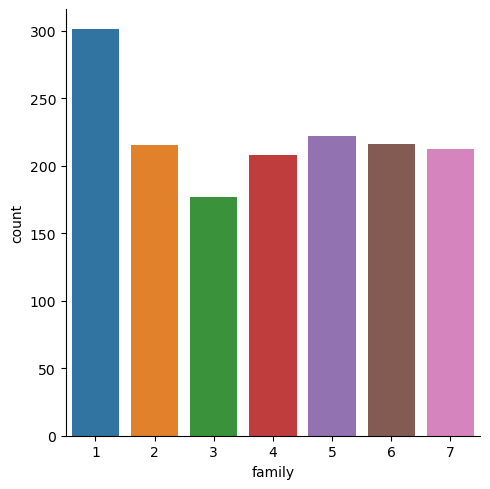

(301, 11) (215, 11) (177, 11) (208, 11) (222, 11) (216, 11) (212, 11)


In [56]:
sns.catplot(x="family", kind="count", order=[1, 2, 3, 4, 5, 6, 7], data=tdSndvi) # order: 보여지는 순서
plt.show()

# 분류항목 확인
lc_list = [1, 2, 3, 4, 5, 6, 7]
for i in range(7):
    globals()[f'lc{i}'] = tdSndvi[tdSndvi['family'] == lc_list[i]]
print(lc0.shape, lc1.shape, lc2.shape, lc3.shape, lc4.shape, lc5.shape, lc6.shape)

In [57]:
# Create training data
tdS.to_csv('./dataCSV/manS_training.csv', index=False)
tdSG.to_csv('./dataCSV/manSG_training.csv', index=False)

tdSndvi.to_csv('./dataCSV/manS_trainingNDVI.csv', index=False)
tdSGndvi.to_csv('./dataCSV/manSG_trainingNDVI.csv', index=False)